# Final Project 
by Tian Song

### Overview:
The purpose of the project is to construct the Fama and French (1996) three-factor model and test its performance on three Exchange-Traded Funds (ETFs). The Fama-French three-factor model is widely used as a benchmark model for stock returns in investment management. It includes three factors: (1) the market factor (MKT), defined as the market return minus one-month T-bill rate, (2) a size factor (Small Minus Big, SMB), defined as the return difference between smallcap versus bigcap stocks, and (3) a book-to-market factor (High Minus Low, HML), defined as the return difference between stocks with high book-to-market ratios and those with low book-to-market ratios. In this project, I first construct these three factors using the historical data, and then test its performance on three ETFs (**SPY**: SPDR S&P 500 ETF Trust; **QQQ**: Invesco QQQ Trust Series 1; and **FXI**: iShares China Large-Cap ETF).

### Data:
Data are from two resources: 

**1. Historical stock returns from 1961 to 2018 are downloaded from Wharton Research Data Services (WRDS) in SAS dataset format. There are three data files:**

    a. acc_6118.sas7bdat: annual accounting reports. Below are the definitions of variables used in the analysis:
      - permno: unique stock identifier
      - datadate: date of fiscal year end
      - seq: stockholders' equity
      - ceq: book value of common equity
      - at: total assets
      - lt: total liabilities
      - txditc: balance sheet deferred taxes and investment tax credits
      - pstkl: liquidating value of preferred stocks
      - pstkrv: redemption value of preferred stocks
      - pstk: par value of preferred stocks

     b. msf_6118.sas7bdat: monthly stock price and returns
      - PERMNO: unqiue stock identifier
      - DATE: (monthly) date
      - RET: stock return
      - prc: closing price (in dollars)
      - shrout: number of shares outstanding (in millions)
      - exchcd: stock exchange code (1: NYSE; 2: American Stock Exchange; 3:Nasdaq)
      - shrcd: share code (10 & 11 for domestic common stocks)

     c. msi_6118.sas7bdat: monthly value-weighted market index return and risk-free rate
      - DATE: (monthly) date
      - vwretd: monthly value-weighted market index return including dividends
      - RF: risk-free rate (one-month T-bill rate)
        

**2. ETF data from 1/2009 to 12/2018 are pulled from Yahoo Finance website using pandas DataReader, including:**

     a. ETF_price: daily price for three ETFs
     b. ETF_dividend: dividend for three ETFs
   
   
### Procedure: 
**1. Construct factors following the procedure in Fama and French (1996).**

Key steps include:
- Impose sample screens to monthly stock returns data
- Construct two key ranking variables: size (market capitalization) and book-to-market (B/M)
- Each month, rank stocks into 2 size groups (S, B) and 3 B/M groups (L, M, H), and form 6 size-B/M portfolios (S/L, S/M, S/H; B/L, B/M, B/H)
- Construct the size factor (Small Minus Big, SMB) as the average return on 3 smallcap portfolios (S/L, S/M, S/H) minus the average return on 3 bigcap portfolios (B/L, B/M, B/H).
- Construct the B/M factor (High Minus Low, HML) as the average return on 2 high B/M portfolios (S/H, B/H) minus the average return on 2 low B/M portfolios (S/L, B/L).
- Construct the market factor (MKT) as the value-weighted market index return minus one-month T-bill rate 
   
Results include: 
- Summary statistics for each of the three factors
- Two sets of plots: (1) the time series of average monthly returns within a calendar year for each factor; (2) the cumulative balance of a buy-and-hold strategy that invests one dollar in each factor.
     
**2. Test the performance of the 3-factor model on ETFs.**

Key steps include:
- Construct monthly returns of the three ETFs using monthly closing price and dividends
- Perform the Fama-French three-factor regression for each of the three ETFs
  
Results include:
- Estimates of the factor regressions: alpha (intercept) and betas (slopes). alpha can be interpreted as abnormal performance of a fund relative to the three-factor model. betas can be interpreted as sensitivities to the factors or exposures to the systematic risk represented by the factors.
- R-squared, which represents the fraction of fund return variations that can be explained by the three-factor model

### Reference
Fama, E.F., and K.R.French. 1996. Multifactor explanation of asset pricing anomalies. *Journal of Finance* 51: 55-84.

## Section One: Constructing factors

### Step 1.1: Data cleaning

In [1]:
#import annual accounting data

import pandas as pd
import numpy as np
import datetime

acc=pd.read_sas('acc_6118.sas7bdat')
acc.head()

,permno,gvkey,datadate,sich,seq,ceq,at,lt,txditc,pstkl,pstkrv,pstk,ajex,csho
0,25881.0,b'001000',1970-12-31,NaN,10.544,10.544,33.450,22.906,0.000,0.000,0.000,0.000,1.0,2.446
1,25881.0,b'001000',1971-12-31,NaN,8.382,8.381,29.330,20.948,0.000,0.000,0.000,0.000,1.0,2.995
2,25881.0,b'001000',1972-12-31,NaN,7.021,7.021,19.907,12.886,0.288,0.000,0.000,0.000,1.0,2.902
3,25881.0,b'001000',1973-12-31,NaN,8.567,8.567,21.771,13.204,0.231,0.000,0.000,0.000,1.0,2.840
4,25881.0,b'001000',1974-12-31,NaN,10.257,9.843,25.638,15.381,0.091,0.414,2.069,0.414,1.0,2.150


In [2]:
#Compute Book Equity (BE)
acc['BE']=np.nan
acc['BE']=acc['seq'].fillna(acc['ceq']+acc['pstk']).fillna(acc['at']-acc['lt'])+acc['txditc'].fillna(0)-acc['pstkrv'].fillna(acc['pstkl']).fillna(acc['pstk'])

#Create a new variable "matching year (myear)" for future merge
acc['myear']=pd.DatetimeIndex(acc['datadate']).year+1

#For a year, some stocks could have multiple annual accounting info (rows) due to fiscal year end change, keep the latest one
acc.sort_values(by=['permno','datadate'], inplace=True)
acc.drop_duplicates(subset=['permno','myear'], keep='last', inplace=True)

#check the updated acc
acc.shape

(244636, 16)

In [3]:
acc.head()

,permno,gvkey,datadate,sich,seq,ceq,at,lt,txditc,pstkl,pstkrv,pstk,ajex,csho,BE,myear
146064,10000.0,b'013007',1986-10-31,NaN,0.418,0.418,2.115,1.697,0.000,0.0,0.0,0.0,1.0,3.843,0.418,1987
145970,10001.0,b'012994',1986-06-30,NaN,5.432,5.432,12.242,6.810,1.605,0.0,0.0,0.0,3.0,0.985,7.037,1987
145971,10001.0,b'012994',1987-06-30,4924.0,5.369,5.369,11.771,6.402,1.669,0.0,0.0,0.0,3.0,0.991,7.038,1988
145972,10001.0,b'012994',1988-06-30,4924.0,5.512,5.512,11.735,6.223,1.774,0.0,0.0,0.0,3.0,0.992,7.286,1989
145973,10001.0,b'012994',1989-06-30,4924.0,6.321,6.321,18.565,12.244,2.145,0.0,0.0,0.0,3.0,1.001,8.466,1990


In [4]:
#import monthly stock price and return data
msf=pd.read_sas('msf_6118.sas7bdat')
msf.head()

,PERMNO,DATE,RET,RETX,CFACSHR,prc,shrout,exchcd,shrcd,siccd
0,10000.0,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000.0,1986-01-31,NaN,NaN,1.0,4.3750,3.680,3.0,10.0,3990.0
2,10000.0,1986-02-28,-0.257143,-0.257143,1.0,3.2500,3.680,3.0,10.0,3990.0
3,10000.0,1986-03-31,0.365385,0.365385,1.0,4.4375,3.680,3.0,10.0,3990.0
4,10000.0,1986-04-30,-0.098592,-0.098592,1.0,4.0000,3.793,3.0,10.0,3990.0


In [6]:
msf.shape

(3295756, 13)

In [5]:
#Create matching year (myear). We will match BE (from acc) from fiscal year ending in t-1 to end of June t to May t+1

msf['year']=pd.DatetimeIndex(msf['DATE']).year
msf['month']=pd.DatetimeIndex(msf['DATE']).month

def matching_year(row):
    if row['month'] in [1,2,3,4,5]:
        myear=row['year']-1
    elif row['month'] in [6,7,8,9,10,11,12]:
        myear=row['year']
    return myear
msf['myear']=msf.apply(matching_year, axis=1)

In [7]:
#Create "returns_all", merging msf with acc, appending BE from acc
msf['permno']=msf['PERMNO']
msf=msf[['permno','DATE','RET','prc','shrout','exchcd', 'shrcd','myear','year','month']]
returns_all=pd.merge(msf, acc[['permno','myear','BE']], on=['permno','myear'], how='left')

In [8]:
#Filter returns_all
#require prc and shrout to be nonmissing
#select data from year 1966 onward
#select domestic common stocks traded on NYSE, AMEX, and Nasdaq
#require BE to be positive
returns_all=returns_all.dropna(subset=['prc','shrout'])
returns_all=returns_all[returns_all['year']>=1966] 
returns_all=returns_all[(returns_all['exchcd']==1) | (returns_all['exchcd']==2) | (returns_all['exchcd']==3)]
returns_all=returns_all[(returns_all['shrcd']==10) | (returns_all['shrcd']==11)]
returns_all=returns_all[returns_all['BE']>0]

returns_all.head()

,permno,DATE,RET,prc,shrout,exchcd,shrcd,myear,year,month,BE
37,10001.0,1987-06-30,0.051429,5.875,0.991,3.0,11.0,1987,1987,6,7.037
38,10001.0,1987-07-31,0.021277,6.000,0.991,3.0,11.0,1987,1987,7,7.037
39,10001.0,1987-08-31,0.083333,6.500,0.991,3.0,11.0,1987,1987,8,7.037
40,10001.0,1987-09-30,-0.022308,6.250,0.992,3.0,11.0,1987,1987,9,7.037
41,10001.0,1987-10-30,0.020000,6.375,0.992,3.0,11.0,1987,1987,10,7.037


In [9]:
#Construct monthly sample for future portfolio returns
returns=msf[['permno','DATE', 'exchcd', 'year', 'month', 'RET']]
returns=returns.dropna(subset=['RET'])

#Create matching year for annual portfolios, and it equals t from July of t to June of t+1
def matching_year_new(row):
    if row['month'] in [1,2,3,4,5,6]:
        myear=row['year']-1
    elif row['month'] in [7,8,9,10,11,12]:
        myear=row['year']
    return myear
returns['myear']=returns.apply(matching_year_new, axis=1)

#For returns of month t, append price and number of shares from end of month t-1
returns['yymm']=returns['year']*12+returns['month']
returns_all['yymm']=returns_all['year']*12+returns_all['month']+1
returns=pd.merge(returns, returns_all[['permno','yymm','prc','shrout']], on=['permno','yymm'])

#Calculate market equity: ME_beg=shrout*Prc
returns['ME_beg']=returns['shrout']*returns['prc']
returns.head()

,permno,DATE,exchcd,year,month,RET,myear,yymm,prc,shrout,ME_beg
0,10001.0,1987-07-31,3.0,1987,7,0.021277,1987,23851,5.875,0.991,5.822125
1,10001.0,1987-08-31,3.0,1987,8,0.083333,1987,23852,6.000,0.991,5.946000
2,10001.0,1987-09-30,3.0,1987,9,-0.022308,1987,23853,6.500,0.991,6.441500
3,10001.0,1987-10-30,3.0,1987,10,0.020000,1987,23854,6.250,0.992,6.200000
4,10001.0,1987-11-30,3.0,1987,11,-0.029412,1987,23855,6.375,0.992,6.324000


### Step 1.2: Construct two ranking variables: Market Equity (ME) and Book to Market (B/M)

In [10]:
#ME (measured annually at end of June)
#Only keep year>=1966 and month=6
ME=returns_all[(returns_all['year']>=1966) & (returns_all['month']==6)]
ME=ME[['permno','myear','prc','shrout','year','month','DATE']]
ME['ME']=ME['prc']*ME['shrout']
ME.head()

,permno,myear,prc,shrout,year,month,DATE,ME
37,10001.0,1987,5.875,0.991,1987,6,1987-06-30,5.822125
49,10001.0,1988,6.250,0.992,1988,6,1988-06-30,6.200000
61,10001.0,1989,7.000,1.001,1989,6,1989-06-30,7.007000
73,10001.0,1990,9.750,1.031,1990,6,1990-06-29,10.052250
85,10001.0,1991,10.500,1.073,1991,6,1991-06-28,11.266500


In [11]:
#B/M (measured annually)
#Get BE information from acc
BE=acc[['permno','datadate','myear','BE']]
BE=BE[(BE['myear']<=2018) & (BE['myear']>=1966)]

#Get ME from end of December
ME_Dec=msf[['permno','DATE','prc','shrout','year','month']]
ME_Dec=ME_Dec.dropna(subset=['prc','shrout'])
ME_Dec['ME_Dec']=ME_Dec['prc']*ME_Dec['shrout']
ME_Dec['myear']=ME_Dec['year']+1
ME_Dec=ME_Dec[(ME_Dec['month']==12) & (ME_Dec['year']>=1965) & (ME_Dec['year']<=2017)]

#merge BE with ME_Dec
BM_1=pd.merge(BE, ME_Dec, on=['permno','myear'])

#Calculate Book to Market Ratio (BM)
BM_1['BM']=BM_1['BE']/BM_1['ME_Dec']

#Require BE>0 and ME_Dec>0
BM_2=BM_1[['permno','myear','BE','ME_Dec','BM']][(BM_1['BE']>0) & (BM_1['ME_Dec']>0)]

BM_2.head()

,permno,myear,BE,ME_Dec,BM
0,10000.0,1987,0.418,1.981547,0.210946
1,10001.0,1987,7.037,6.937000,1.014415
2,10001.0,1988,7.038,5.828000,1.207618
3,10001.0,1989,7.286,6.362250,1.145192
4,10001.0,1990,8.466,10.347750,0.818149


### Step 1.3: Rank on ME and BM seperately

In [12]:
#rank on ME
#first filter based on month, only keep June
returns_all_june=returns_all[returns_all['month']==6]

#Merge stock exchange code (exchcd) with makert equity (ME)
June_ME=pd.merge(returns_all_june[['permno','myear','exchcd']], ME[['permno','myear','ME']], on=['permno','myear'])

#Select the NYSE stocks, the portfolio breakpoints are based on NYSE stocks only
June_ME_NYSE=June_ME[June_ME['exchcd']==1]

#For each year, get the 50th percentile of ME
ME_cut=June_ME_NYSE[['myear','ME']].groupby('myear', as_index=False).quantile(.5).rename(columns={'ME': 'P50'})
ME_cut.head()

0.5,myear,P50
0,1966.0,133.5705
1,1967.0,151.8750
2,1968.0,181.1745
3,1969.0,162.6060
4,1970.0,105.3250


In [13]:
#Append the cutoff to all stocks (exchcd=1,2 and 3)
June_ME=pd.merge(June_ME, ME_cut, on='myear')

#Put stock into  two categories: if ME<=P50, then rank_ME=1, otherwise rank_ME=2. The stocks are catergorized into 
#two groups: samllcap company and bigcap company
def rank_ME(row):
    if row['ME']<=row['P50']:
        rank_ME=1
    else:
        rank_ME=2
    return rank_ME
June_ME['rank_ME']=June_ME.apply(rank_ME, axis=1)

#check the number of companies in each group for each year
June_ME.groupby(['myear','rank_ME'])['ME'].count()

myear  rank_ME
1966   1           751
       2           440
1967   1           953
       2           472
1968   1          1023
       2           488
1969   1          1124
       2           538
1970   1          1265
       2           574
1971   1          1354
       2           608
1972   1          1424
       2           650
1973   1          2062
       2           790
1974   1          2664
       2           823
1975   1          2949
       2           814
1976   1          2964
       2           805
1977   1          2964
       2           806
1978   1          2892
       2           792
1979   1          2898
       2           781
1980   1          2995
       2           788
                  ... 
2004   1          3585
       2           933
2005   1          3573
       2           913
2006   1          3505
       2           888
2007   1          3436
       2           868
2008   1          3380
       2           875
2009   1          3086
       2           

In [14]:
#Rank on BM

#Merge stock exchange code (exchcd) with book-to-market ratio (BM)
June_BM=pd.merge(returns_all_june[['permno','myear','exchcd']], BM_2[['permno','myear','BM']], on=['permno','myear'])

#Select the NYSE stocks, the portfolio breakpoints be based on NYSE stocks only
June_BM_NYSE=June_BM[June_BM['exchcd']==1]

#Get the 30th and 70th percentiles of BM for each year
BM_cut=June_BM_NYSE[['myear','BM']].groupby('myear', as_index=False).quantile([.3, .7]).reset_index()
BM_cut.head()

,level_0,level_1,myear,BM
0,0,0.3,1966.0,0.411676
1,0,0.7,1966.0,0.717557
2,1,0.3,1967.0,0.490344
3,1,0.7,1967.0,0.890504
4,2,0.3,1968.0,0.384404


In [15]:
#Reshape data from long to wide
def change_name(row):
    if row['level_1']==0.3:
        cut='P30'
    elif row['level_1']==0.7:
        cut='P70'
    return cut
BM_cut['cut']=BM_cut.apply(change_name, axis=1)

BM_cut_reshape=BM_cut.pivot(index='myear',columns='cut',values='BM').reset_index()
BM_cut_reshape.head()

cut,myear,P30,P70
0,1966.0,0.411676,0.717557
1,1967.0,0.490344,0.890504
2,1968.0,0.384404,0.715705
3,1969.0,0.325820,0.611432
4,1970.0,0.467294,0.888762


In [16]:
#Merge percentile cut offs to all stocks
June_BM=pd.merge(June_BM, BM_cut_reshape, on='myear')

#Divide stocks into three categories: low-, Mediuem-, High-BM companies
def rank_BM(row):
    if row['BM']<=row['P30']:
        rank_BM=1
    elif row['P30']<row['BM']<=row['P70']:
        rank_BM=2
    else:
        rank_BM=3
    return rank_BM
June_BM['rank_BM']=June_BM.apply(rank_BM, axis=1)
June_BM.head()

,permno,myear,exchcd,BM,P30,P70,rank_BM
0,10001.0,1987,3.0,1.014415,0.523353,0.946189,3
1,10005.0,1987,3.0,4.381035,0.523353,0.946189,3
2,10007.0,1987,3.0,0.043989,0.523353,0.946189,1
3,10008.0,1987,3.0,0.528534,0.523353,0.946189,2
4,10010.0,1987,3.0,0.674402,0.523353,0.946189,2


In [17]:
#Merge ranking with returns
ret_ME=pd.merge(returns, June_ME[['permno','myear','rank_ME']], on=['permno','myear'])
ret_ME_BM=pd.merge(ret_ME, June_BM[['permno','myear','rank_BM']], on=['permno','myear'])
ret_ME_BM.head()

,permno,DATE,exchcd,year,month,RET,myear,yymm,prc,shrout,ME_beg,rank_ME,rank_BM
0,10001.0,1987-07-31,3.0,1987,7,0.021277,1987,23851,5.875,0.991,5.822125,1,3
1,10001.0,1987-08-31,3.0,1987,8,0.083333,1987,23852,6.000,0.991,5.946000,1,3
2,10001.0,1987-09-30,3.0,1987,9,-0.022308,1987,23853,6.500,0.991,6.441500,1,3
3,10001.0,1987-10-30,3.0,1987,10,0.020000,1987,23854,6.250,0.992,6.200000,1,3
4,10001.0,1987-11-30,3.0,1987,11,-0.029412,1987,23855,6.375,0.992,6.324000,1,3


In [18]:
#Calculate the value-weighted portfolio returns

#Get total ME_beg within each year-month combination
weight_total=ret_ME_BM.groupby(['rank_ME','rank_BM','year','month'], as_index=False).agg({'ME_beg':['sum']})
weight_total.columns = weight_total.columns.droplevel(1); 
weight_total=weight_total.rename(columns={'ME_beg':'ME_total'})

pret_ME_BM=pd.merge(ret_ME_BM, weight_total[['rank_ME','rank_BM','year','month','ME_total']], on=['rank_ME','rank_BM','year','month'])

pret_ME_BM['ret_VW']=pret_ME_BM['RET']*pret_ME_BM['ME_beg']/pret_ME_BM['ME_total']*100
pret_ME_BM.head()

,permno,DATE,exchcd,year,month,RET,myear,yymm,prc,shrout,ME_beg,rank_ME,rank_BM,ME_total,ret_VW
0,10001.0,1987-07-31,3.0,1987,7,0.021277,1987,23851,5.87500,0.991,5.822125,1,3,73263.375875,0.000169
1,10005.0,1987-07-31,3.0,1987,7,0.714286,1987,23851,0.21875,4.626,1.011938,1,3,73263.375875,0.000987
2,10016.0,1987-07-31,3.0,1987,7,0.082759,1987,23851,72.50000,4.586,332.485000,1,3,73263.375875,0.037558
3,10046.0,1987-07-31,3.0,1987,7,0.000000,1987,23851,1.12500,1.569,1.765125,1,3,73263.375875,0.000000
4,10047.0,1987-07-31,3.0,1987,7,-0.163636,1987,23851,6.87500,3.718,25.561250,1,3,73263.375875,-0.005709


### Step 1.4: Construct factors

In [19]:
#constrcut the SMB factor
#SMB (Small Minus Big) is the average return on the three small portfolios minus the average return on the three big 
#portfolios 
pret_ME_BM_agg=pret_ME_BM.groupby(['rank_ME','rank_BM','year','month'], as_index=False).agg({'ret_VW':['sum']})
pret_ME_BM_agg.columns = pret_ME_BM_agg.columns.droplevel(1); 

pret_ME_1=pret_ME_BM_agg[pret_ME_BM_agg['rank_ME']==1]
pret_ME_2=pret_ME_BM_agg[pret_ME_BM_agg['rank_ME']==2]
SMB=pd.merge(pret_ME_1, pret_ME_2, on=['year','month','rank_BM'])

SMB['SMB']=SMB['ret_VW_x']-SMB['ret_VW_y']
SMB_factor=SMB.groupby(['year','month'], as_index=False).agg({'SMB':'mean'})
SMB_factor

,year,month,SMB
0,1966,7,-0.089961
1,1966,8,-2.957010
2,1966,9,-1.526473
3,1966,10,-5.119876
4,1966,11,3.834424
5,1966,12,1.985190
6,1967,1,7.926109
7,1967,2,2.409928
8,1967,3,1.834151
9,1967,4,0.600463


In [20]:
#Construct the HML factor
#HML (High Minus Low) is the average return on the two value portfolios minus the average return on the 
#two growth portfolios
pret_BM_1=pret_ME_BM_agg[pret_ME_BM_agg['rank_BM']==1]
pret_BM_3=pret_ME_BM_agg[pret_ME_BM_agg['rank_BM']==3]
HML=pd.merge(pret_BM_1, pret_BM_3, on=['year','month','rank_ME'])

HML['HML']=HML['ret_VW_y']-HML['ret_VW_x']
HML_factor=HML.groupby(['year','month'], as_index=False).agg({'HML':'mean'})
HML_factor

,year,month,HML
0,1966,7,0.975682
1,1966,8,0.762847
2,1966,9,1.430804
3,1966,10,3.147230
4,1966,11,-5.317844
5,1966,12,-0.510195
6,1967,1,0.947293
7,1967,2,-2.250745
8,1967,3,-0.148900
9,1967,4,-1.403462


In [22]:
#Construct the Market factor (market index return minus one-month T-bill rate)
msi=pd.read_sas('msi_6118.sas7bdat')
msi['MKT']=msi['vwretd']-msi['RF']
msi['year']=pd.DatetimeIndex(msi['DATE']).year
msi['month']=pd.DatetimeIndex(msi['DATE']).month
MKT_factor=msi[['year','month','MKT','RF']]
MKT_factor

,year,month,MKT,RF
0,1961,1,6.201240,0.1940
1,1961,2,3.535565,0.1649
2,1961,3,2.859792,0.2012
3,1961,4,0.389873,0.1746
4,1961,5,2.412007,0.1774
5,1961,6,-3.050706,0.2008
6,1961,7,2.813065,0.1824
7,1961,8,2.549641,0.1358
8,1961,9,-2.166736,0.1677
9,1961,10,2.541013,0.1921


In [23]:
#Create the time series of factor returns

#Combine SMB and HML factors
SMB_HML=pd.merge(SMB_factor, HML_factor, on=['year','month'])

#Merge SMB, HML with MKT
FF3=pd.merge(SMB_HML, MKT_factor, on=['year','month'])
FF3.head()

,year,month,SMB,HML,MKT,RF
0,1966,7,-0.089961,0.975682,-1.671718,0.3847
1,1966,8,-2.957010,0.762847,-7.950654,0.4119
2,1966,9,-1.526473,1.430804,-1.084812,0.3890
3,1966,10,-5.119876,3.147230,3.790521,0.4389
4,1966,11,3.834424,-5.317844,1.358437,0.3932


### Step 1.5: Summary Statistics and Plots

In [24]:
#Descriptive Statistics
FF3.describe().drop(columns=['year','month','RF'])

,SMB,HML,MKT
count,630.000000,630.000000,630.000000
mean,0.187179,0.303527,0.490086
std,3.074411,2.897832,4.475404
min,-16.738997,-13.369856,-23.140300
25%,-1.682623,-1.403282,-2.162354
50%,0.064377,0.256918,0.869614
75%,1.964805,1.697050,3.494324
max,21.765961,13.751875,16.033020


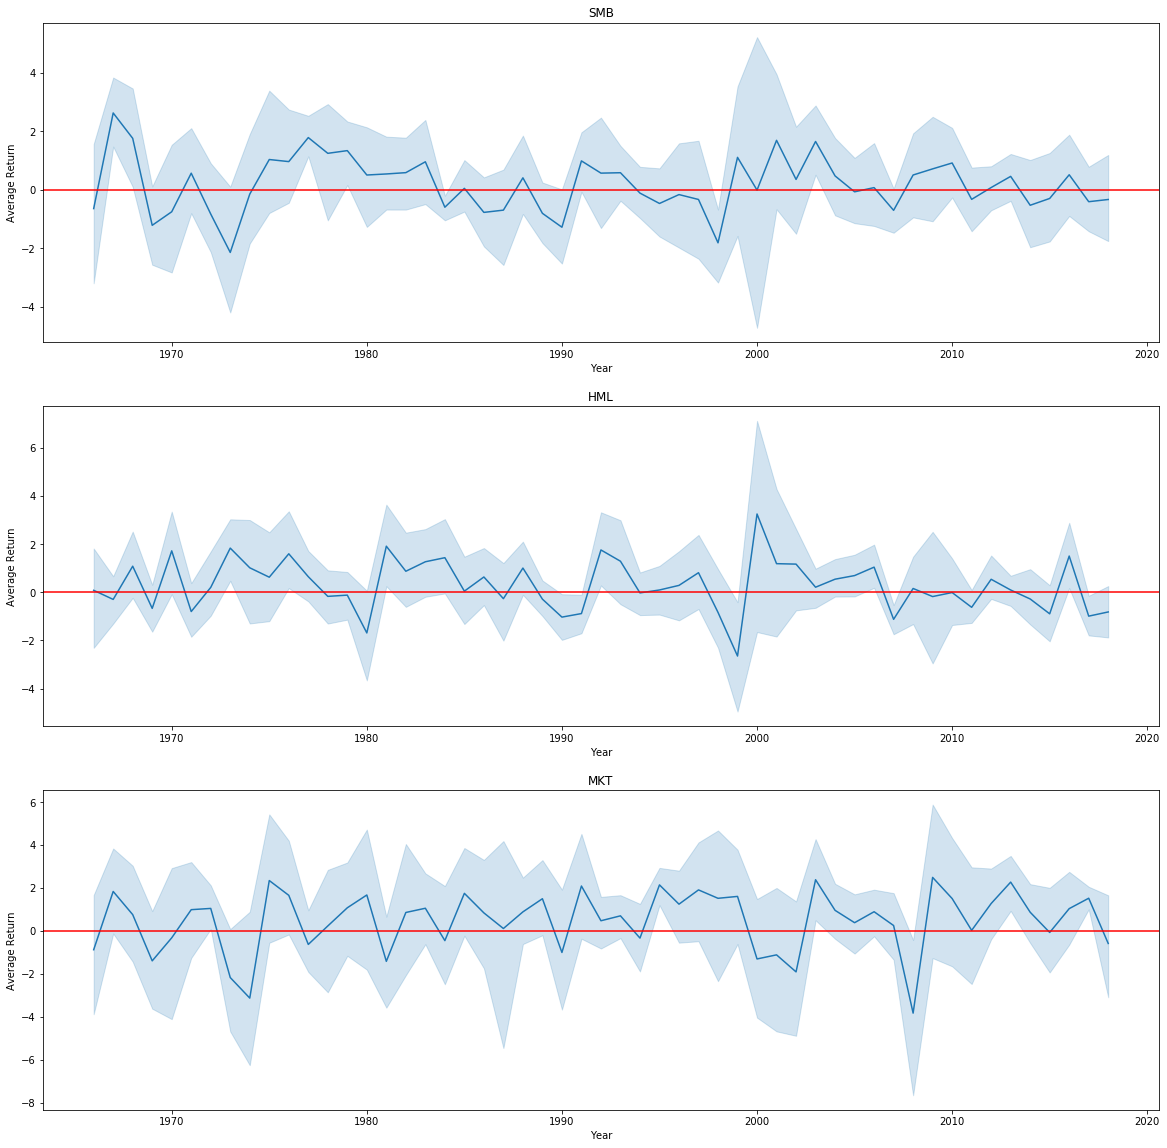

In [25]:
#Plot factors

#Plot 1: Times-series of mean monthly returns within a calendar year

average_by_year=FF3.groupby('year',as_index=False).mean()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

fig, ax= plt.subplots(3,1,figsize=(20,20))
sns.lineplot(x='year', y='SMB', data=FF3, ax=ax[0])
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Average Return')
ax[0].set_title('SMB')
ax[0].axhline(y=0, color='r', linestyle='-');

sns.lineplot(x='year', y='HML', data=FF3, ax=ax[1])
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Average Return')
ax[1].set_title('HML')
ax[1].axhline(y=0, color='r', linestyle='-');

sns.lineplot(x='year', y='MKT', data=FF3, ax=ax[2])
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Average Return')
ax[2].set_title('MKT')
ax[2].axhline(y=0, color='r', linestyle='-');

Comments: In most years, the factors have postive returns. That is, smallcaps outperform larage caps, value stocks outperform growth stocks, and stocks outperform T-bills (a positive risk premium).


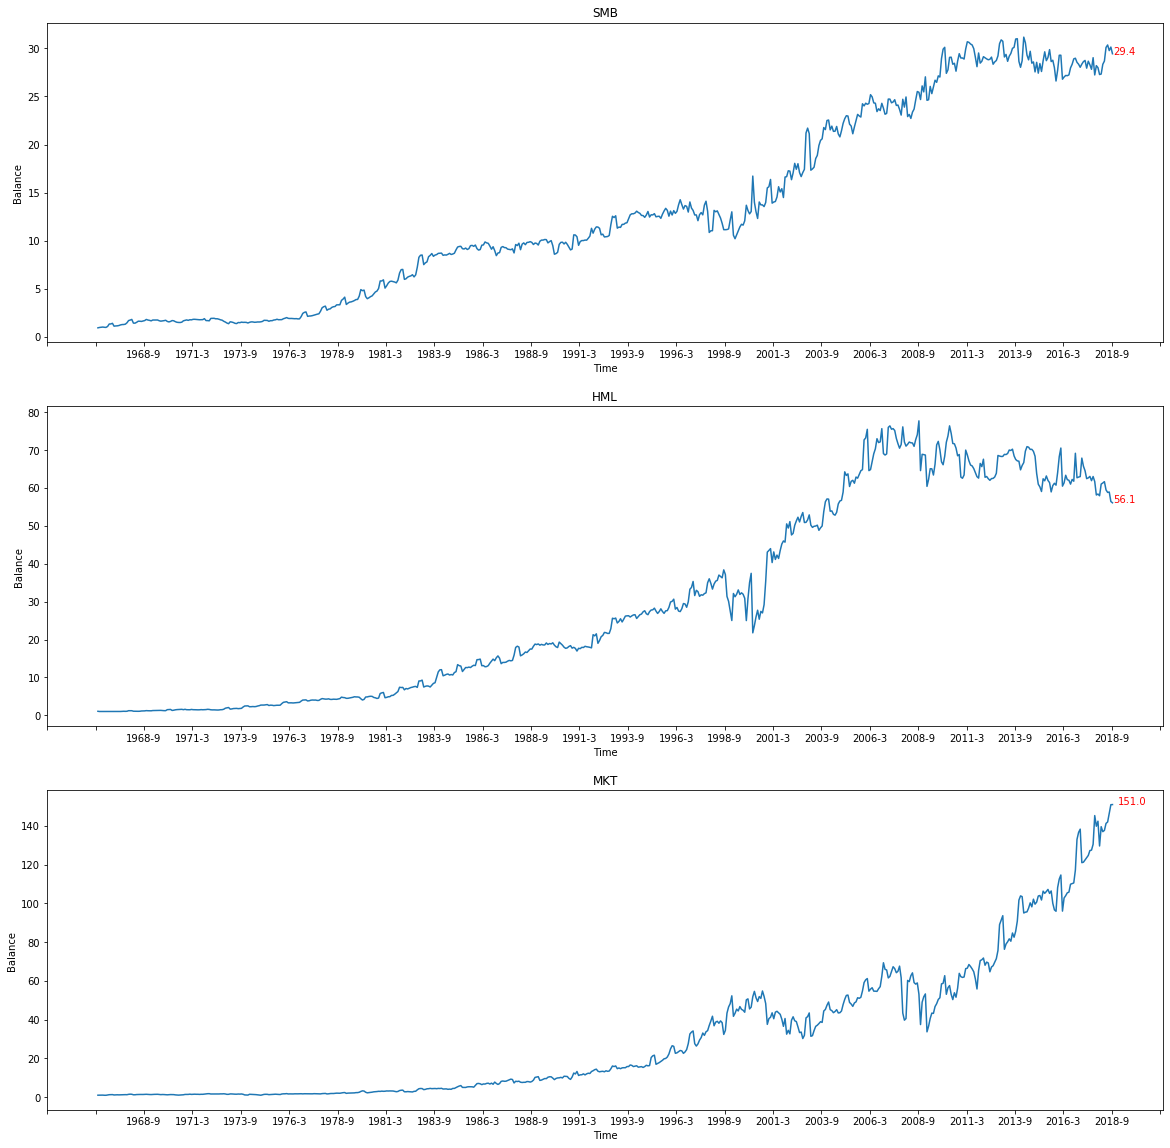

In [27]:
#Plot 2: We invest 1 dollor at the beginning of 7/1966 on SMB/HML/MKT factors and hold the poisition.
#The plot shows the cummulated dollar balance.
#for example, return_end=(1+r_1)*(1+r_2)......, where r_t=factor_t+risk-free rate

import math

def SMB_log(row):
    SMB_log=math.log(row['SMB']/100+1+row['RF']/100)
    return SMB_log
FF3['SMB_log']=FF3.apply(SMB_log, axis=1)

def HML_log(row):
    HML_log=math.log(row['HML']/100+1+row['RF']/100)
    return HML_log
FF3['HML_log']=FF3.apply(HML_log, axis=1)

def MKT_log(row):
    MKT_log=math.log(row['MKT']/100+1+row['RF']/100)
    return MKT_log
FF3['MKT_log']=FF3.apply(MKT_log, axis=1)

FF3[['SMB_cum','HML_cum','MKT_cum']]=FF3[['SMB_log','HML_log','MKT_log']].cumsum(axis=0)

FF3['SMB_r']=FF3['SMB_cum'].apply(lambda SMB_cum: math.exp(SMB_cum) )
FF3['HML_r']=FF3['HML_cum'].apply(lambda HML_cum: math.exp(HML_cum) )
FF3['MKT_r']=FF3['MKT_cum'].apply(lambda MKT_cum: math.exp(MKT_cum) )

def timeseries(row):
    Time=str(int(row['year']))+'-'+str(row['month'])
    return Time
FF3['Time']=FF3.apply(timeseries,axis=1)

fig, ax= plt.subplots(3,1,figsize=(20,20))
sns.lineplot(x='Time', y='SMB_r', data=FF3, ax=ax[0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Balance')
ax[0].set_title('SMB')
start, end = ax[0].get_xlim()
ax[0].xaxis.set_ticks(np.arange(start, end, 30))
ax[0].annotate('29.4', # this is the text
                 ('2018-12',29.4), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,0), # distance from text to points (x,y)
                 ha='center', color='r');

sns.lineplot(x='Time', y='HML_r', data=FF3, ax=ax[1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Balance')
ax[1].set_title('HML')
start, end = ax[1].get_xlim()
ax[1].xaxis.set_ticks(np.arange(start, end, 30))
ax[1].annotate('56.1', # this is the text
                 ('2018-12',56.1), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,0), # distance from text to points (x,y)
                 ha='center', color='r');

sns.lineplot(x='Time', y='MKT_r', data=FF3, ax=ax[2])
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Balance')
ax[2].set_title('MKT')
start, end = ax[2].get_xlim()
ax[2].xaxis.set_ticks(np.arange(start, end, 30))
ax[2].annotate('151.0', # this is the text
                 ('2018-9',151.0), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,0), # distance from text to points (x,y)
                 ha='center', color='r');

Comments: If we invest one dollor in each of these three factors in July 1966 and hold it, by the end of September 2018, the cumulative dollar balance will reach to 29.5, 56.1, and 151.0 respectivly. 


## Section Two: Model Testing

### Step 2.1 Pull ETF data from Yahoo Finance

In [28]:
#Pull ETF historical data from Yahoo Finance

from pandas_datareader import data
# Define the instruments to download
tickers = ['SPY', 'QQQ', 'FXI']

# Obtain data from 01/01/2009 to 12/31/2018.
start_date = '2009-01-01'
end_date = '2018-12-31'

# User pandas DataReader to load the data
ETF_price = data.DataReader(tickers, 'yahoo', start_date, end_date)
ETF_price.head()

Attributes  Adj Close                            Close                        \
Symbols           FXI        QQQ        SPY        FXI        QQQ        SPY   
Date                                                                           
2009-01-02  24.814196  27.853317  74.754257  31.110001  31.030001  92.959999   
2009-01-05  25.093367  27.844337  74.665771  31.459999  31.020000  92.849998   
2009-01-06  25.173126  28.122604  75.164375  31.559999  31.330000  93.470001   
2009-01-07  23.370491  27.323717  72.912735  29.299999  30.440001  90.669998   
2009-01-08  22.955721  27.610966  73.210289  28.780001  30.760000  91.040001   

Attributes       High                              Low                        \
Symbols           FXI        QQQ        SPY        FXI        QQQ        SPY   
Date                                                                           
2009-01-02  31.190001  31.129999  93.440002  29.799999  29.690001  89.849998   
2009-01-05  31.870001  31.330000  93.660004  31.129999  30.590000  91.889999   
2009-01-06  32.200001  31.629999  94.449997  31.400000  31.110001  92.680000   
2009-01-07  29.900000  30.900000  92.260002  29.139999  30.190001  90.199997   
2009-01-08  28.830000  30.799999  91.089996  28.150000  30.080000  89.669998   

Attributes       Open                            Volume               \
Symbols           FXI        QQQ        SPY         FXI          QQQ   
Date                                                                   
2009-01-02  30.000000  29.750000  90.440002  26744600.0  107891500.0   
2009-01-05  31.270000  30.830000  92.629997  25228400.0   91751900.0   
2009-01-06  31.690001  31.250000  93.639999  30877500.0  136791700.0   
2009-01-07  29.870001  30.730000  92.000000  40846800.0  133879800.0   
2009-01-08  28.290001  30.379999  90.160004  27251900.0  131926600.0   

Attributes               
Symbols             SPY  
Date                     
2009-01-02  227566300.0  
2009-01-05  240349700.0  
2009-01-06  328260900.0  
2009-01-07  280899200.0  
2009-01-08  263834400.0

In [29]:
#This is daily data. We need monthly data for our test, so select the closing price at the end of each month
ETF_close= ETF_price['Close'].reset_index()
ETF_close ['year_month']= pd.to_datetime(ETF_close['Date']).dt.to_period('M')
ETF_close.sort_values(by='Date', inplace=True)
ETF_close.drop_duplicates(subset=['year_month'], keep='last', inplace=True)

In [30]:
# Load dividend data
ETF_dividend = data.DataReader(tickers, 'yahoo-actions', start_date, end_date)
ETF_dividend
#it is dictionary

{'FXI':               action     value
 2018-12-18  DIVIDEND  0.446000
 2018-06-19  DIVIDEND  0.605000
 2017-12-21  DIVIDEND  0.892000
 2017-06-20  DIVIDEND  0.176000
 2016-12-22  DIVIDEND  0.689194
 2016-06-21  DIVIDEND  0.244329
 2015-12-21  DIVIDEND  0.774740
 2015-06-24  DIVIDEND  0.249278
 2014-12-19  DIVIDEND  0.505675
 2014-06-24  DIVIDEND  0.539866
 2013-12-17  DIVIDEND  0.174332
 2013-06-25  DIVIDEND  0.839003
 2012-12-17  DIVIDEND  0.086000
 2012-06-20  DIVIDEND  0.851000
 2011-12-19  DIVIDEND  0.079000
 2011-06-21  DIVIDEND  0.686000
 2010-12-20  DIVIDEND  0.169000
 2010-06-21  DIVIDEND  0.459000
 2009-12-21  DIVIDEND  0.222000
 2009-06-22  DIVIDEND  0.326000, 'QQQ':               action  value
 2018-12-24  DIVIDEND  0.421
 2018-09-24  DIVIDEND  0.330
 2018-06-18  DIVIDEND  0.378
 2018-03-19  DIVIDEND  0.277
 2017-12-18  DIVIDEND  0.329
 2017-09-18  DIVIDEND  0.319
 2017-06-16  DIVIDEND  0.378
 2017-03-17  DIVIDEND  0.274
 2016-12-16  DIVIDEND  0.355
 2016-09-16  DIVIDEND  0

In [31]:
#change to dataframe
SPY_dividend = ETF_dividend['SPY']['value'].reset_index().rename(columns={'index':'date', 'value':'SPY_dividend'})
SPY_dividend ['year_month']= pd.to_datetime(SPY_dividend['date']).dt.to_period('M')

QQQ_dividend = ETF_dividend['QQQ']['value'].reset_index().rename(columns={'index':'date', 'value':'QQQ_dividend'})
QQQ_dividend ['year_month']= pd.to_datetime(QQQ_dividend['date']).dt.to_period('M')

FXI_dividend = ETF_dividend['FXI']['value'].reset_index().rename(columns={'index':'date', 'value':'FXI_dividend'})
FXI_dividend ['year_month']= pd.to_datetime(FXI_dividend['date']).dt.to_period('M')

SPY_dividend.head()

,date,SPY_dividend,year_month
0,2018-12-21,1.435,2018-12
1,2018-09-21,1.323,2018-09
2,2018-06-15,1.246,2018-06
3,2018-03-16,1.097,2018-03
4,2017-12-15,1.351,2017-12


### Step 2.2: Prepare data for modeling

In [32]:
#Merge monthly closing price with monthly dividend
ETF_close=pd.merge(ETF_close, SPY_dividend[['year_month','SPY_dividend']], on='year_month', how='left')
ETF_close=pd.merge(ETF_close, QQQ_dividend[['year_month','QQQ_dividend']], on='year_month', how='left')
ETF_close=pd.merge(ETF_close, FXI_dividend[['year_month','FXI_dividend']], on='year_month', how='left')
ETF_close.head()

,Date,FXI,QQQ,SPY,year_month,SPY_dividend,QQQ_dividend,FXI_dividend
0,2009-01-30,25.110001,29.059999,82.830002,2009-01,NaN,NaN,NaN
1,2009-02-27,24.309999,27.530001,73.930000,2009-02,NaN,NaN,NaN
2,2009-03-31,28.530001,30.320000,79.519997,2009-03,0.561,0.049,NaN
3,2009-04-30,31.980000,34.279999,87.419998,2009-04,NaN,NaN,NaN
4,2009-05-29,37.369999,35.380001,92.529999,2009-05,NaN,NaN,NaN


In [33]:
#Calculate return: return=(price-price_one_month_lagged+dividend)/price_one_month_lagged*100
ETF_close['SPY_lag']=ETF_close['SPY'].shift(1)
ETF_close['QQQ_lag']=ETF_close['QQQ'].shift(1)
ETF_close['FXI_lag']=ETF_close['FXI'].shift(1)

ETF_close[['SPY_dividend','QQQ_dividend','FXI_dividend']]=ETF_close[['SPY_dividend','QQQ_dividend','FXI_dividend']].fillna(0)

ETF_close['Rt_SPY']=(ETF_close['SPY']-ETF_close['SPY_lag']+ETF_close['SPY_dividend'])/ETF_close['SPY_lag']*100
ETF_close['Rt_QQQ']=(ETF_close['QQQ']-ETF_close['QQQ_lag']+ETF_close['QQQ_dividend'])/ETF_close['QQQ_lag']*100
ETF_close['Rt_FXI']=(ETF_close['FXI']-ETF_close['FXI_lag']+ETF_close['FXI_dividend'])/ETF_close['FXI_lag']*100
ETF_close.head()

,Date,FXI,QQQ,SPY,year_month,SPY_dividend,QQQ_dividend,FXI_dividend,SPY_lag,QQQ_lag,FXI_lag,Rt_SPY,Rt_QQQ,Rt_FXI
0,2009-01-30,25.110001,29.059999,82.830002,2009-01,0.000,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-02-27,24.309999,27.530001,73.930000,2009-02,0.000,0.000,0.0,82.830002,29.059999,25.110001,-10.744901,-5.264965,-3.185986
2,2009-03-31,28.530001,30.320000,79.519997,2009-03,0.561,0.049,0.0,73.930000,27.530001,24.309999,8.320027,10.312383,17.359117
3,2009-04-30,31.980000,34.279999,87.419998,2009-04,0.000,0.000,0.0,79.519997,30.320000,28.530001,9.934610,13.060683,12.092530
4,2009-05-29,37.369999,35.380001,92.529999,2009-05,0.000,0.000,0.0,87.419998,34.279999,31.980000,5.845345,3.208875,16.854282


In [34]:
#Construct data for factor regressions
ETF_close['year']=pd.DatetimeIndex(ETF_close['Date']).year
ETF_close['month']=pd.DatetimeIndex(ETF_close['Date']).month

ETF_regression=pd.merge(ETF_close, FF3, on=['year','month'])
ETF_regression.head()

,Date,FXI,QQQ,SPY,year_month,SPY_dividend,QQQ_dividend,FXI_dividend,SPY_lag,QQQ_lag,...,SMB_log,HML_log,MKT_log,SMB_cum,HML_cum,MKT_cum,SMB_r,HML_r,MKT_r,Time
0,2009-01-30,25.110001,29.059999,82.830002,2009-01,0.000,0.000,0.0,NaN,NaN,...,-0.010745,-0.095306,-0.080467,3.206046,4.167574,3.621814,24.681313,64.558643,37.405350,2009-1
1,2009-02-27,24.309999,27.530001,73.930000,2009-02,0.000,0.000,0.0,82.830002,29.059999,...,-0.003293,-0.066555,-0.105661,3.202753,4.101019,3.516153,24.600163,60.401780,33.654693,2009-2
2,2009-03-31,28.530001,30.320000,79.519997,2009-03,0.561,0.049,0.0,73.930000,27.530001,...,0.002415,0.030061,0.083189,3.205168,4.131080,3.599342,24.659642,62.245108,36.574158,2009-3
3,2009-04-30,31.980000,34.279999,87.419998,2009-04,0.000,0.000,0.0,79.519997,30.320000,...,0.054741,0.044187,0.103776,3.259909,4.175267,3.703118,26.047175,65.057208,40.573622,2009-4
4,2009-05-29,37.369999,35.380001,92.529999,2009-05,0.000,0.000,0.0,87.419998,34.279999,...,-0.029246,-0.000387,0.065577,3.230663,4.174880,3.768695,25.296421,65.032044,43.323478,2009-5


### Step 3.3: Modeling

In [40]:
#Regression for SPY
#Return is the target, and three factors (SMB, HML, MKT) are regressors
ETF_reg_SPY=ETF_regression.dropna(subset=['Rt_SPY'])
X=ETF_reg_SPY[['SMB','HML','MKT']]
y=ETF_reg_SPY['Rt_SPY']-ETF_reg_SPY['RF']

from sklearn.linear_model import LinearRegression
model=LinearRegression(fit_intercept=True)
model.fit(X,y)
print(model.score(X,y))
print(model.intercept_)
print(model.coef_)

0.9769203099761469
0.12059668871760687
[-0.14012312 -0.03216767  0.98430653]


In [43]:
#We need to perform statistical inference, so I rerun the linear regression in statsmodels package

import statsmodels.api as sm
X = sm.add_constant(X)
model=sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1651.
Date:                Fri, 04 Oct 2019   Prob (F-statistic):           1.52e-95
Time:                        12:31:27   Log-Likelihood:                -105.29
No. Observations:                 121   AIC:                             218.6
Df Residuals:                     117   BIC:                             229.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1206      0.056      2.163      0.033       0.010       0.231
SMB           -0.1401      0.024     -5.719      0.000      -0.189      -0.092
HML           -0.0322      0.024     -1.339      0.183      -0.080       0.015
MKT            0.9843      0.015     65.603      0.000       0.955       1.014
==============================================================================
Omnibus:                      164.522   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9005.186
Skew:                           4.883   Prob(JB):                         0.00
Kurtosis:                      44.119   Cond. No.                         4.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
#QQQ regression
ETF_reg_QQQ=ETF_regression.dropna(subset=['Rt_QQQ'])
X=ETF_reg_QQQ[['SMB','HML','MKT']]
y=ETF_reg_QQQ['Rt_QQQ']-ETF_reg_QQQ['RF']

X = sm.add_constant(X)
model=sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     256.8
Date:                Fri, 04 Oct 2019   Prob (F-statistic):           2.72e-51
Time:                        12:31:31   Log-Likelihood:                -229.80
No. Observations:                 121   AIC:                             467.6
Df Residuals:                     117   BIC:                             478.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3439      0.156      2.204      0.029       0.035       0.653
SMB           -0.0987      0.069     -1.440      0.152      -0.235       0.037
HML           -0.4895      0.067     -7.284      0.000      -0.623      -0.356
MKT            1.1073      0.042     26.372      0.000       1.024       1.190
==============================================================================
Omnibus:                        0.588   Durbin-Watson:                   2.226
Prob(Omnibus):                  0.745   Jarque-Bera (JB):                0.667
Skew:                          -0.159   Prob(JB):                        0.716
Kurtosis:                       2.825   Cond. No.                         4.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
#FXI Regression
ETF_reg_FXI=ETF_regression.dropna(subset=['Rt_FXI'])
X=ETF_reg_FXI[['SMB','HML','MKT']]
y=ETF_reg_FXI['Rt_FXI']-ETF_reg_FXI['RF']

X = sm.add_constant(X)
model=sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     32.08
Date:                Fri, 04 Oct 2019   Prob (F-statistic):           3.32e-15
Time:                        12:31:36   Log-Likelihood:                -358.96
No. Observations:                 121   AIC:                             725.9
Df Residuals:                     117   BIC:                             737.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4774      0.454     -1.052      0.295      -1.376       0.421
SMB           -0.2885      0.199     -1.447      0.150      -0.683       0.106
HML           -0.2716      0.195     -1.390      0.167      -0.659       0.115
MKT            1.1616      0.122      9.514      0.000       0.920       1.403
==============================================================================
Omnibus:                        3.084   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                3.258
Skew:                          -0.028   Prob(JB):                        0.196
Kurtosis:                       3.802   Cond. No.                         4.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Step 3.4: Interpretation of Results

The Fama-French 3-factor model works well for SPY, with 97.7% of return variations explained by the three factors (see R-squared). SPY is based on the S&P 500 index, which captures more than 90% in value of the market. As a result, the loading on the market factor (MKT) is very close to 1. However, there is also a small issue with the model. Even as a passive index ETF, SPY has a significant albeit small alpha of 0.12% per month (t=2.16). In other words, a popular passive ETF can beat the Fama-French model.

QQQ is based on the Nasdaq 100 index, which has a big exposure to big technology stocks such as Apple, Google, and Microsoft. The model works reasonally well here, explaining 86.8% of QQQ's return variations. The technology companies are noramlly big companies with low book-market ratio, so the coefficients for SMB and HML in our model are both negative. In our sampel peirod, QQQ signifiantly outperform the benchmark model by 0.34% per month (t=2.20), which is about 4% per year.

FXI is based on an index of largecap Chinese stocks. The model explains only 45.1% of return variations. This is not surprising since the model is derived using US common stocks. On the other hand, FXI has a loading close to 1 on the market factor. So, FIX tends to fluctuate in the same direction of the US stock market.
